In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import hvplot
from matplotlib import cm
from datetime import datetime
from pyproj import Transformer
# import holoviews as hv
# from holoviews import opts

# hv.extension('bokeh', 'matplotlib')

In [83]:
%run -i ncbx_funcs.py

In [2]:
url_CSNV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw44/Output/dorian_his.ncml'
url_CSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/dorian_his.ncml'
url_FSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/dorian_his.ncml'
url_FSNV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw51/Output/dorian_his.ncml'
#url_CSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/dorian_his.ncml'
ds_CSYV = xr.open_dataset(url_CSYV)
ds_CSYV

<xarray.Dataset>
Dimensions:                 (tracer: 4, NST: 3, s_rho: 8, s_w: 9,
                             eta_rho: 1057, xi_rho: 1317, eta_u: 1057,
                             xi_u: 1316, eta_v: 1056, xi_v: 1317,
                             eta_psi: 1056, xi_psi: 1316, ocean_time: 37,
                             NVEG: 3, Nbed: 1)
Coordinates:
  * s_rho                   (s_rho) float64 -0.9375 -0.8125 ... -0.1875 -0.0625
  * s_w                     (s_w) float64 -1.0 -0.875 -0.75 ... -0.25 -0.125 0.0
    lon_rho                 (eta_rho, xi_rho) float64 ...
    lat_rho                 (eta_rho, xi_rho) float64 ...
    lon_u                   (eta_u, xi_u) float64 ...
    lat_u                   (eta_u, xi_u) float64 ...
    lon_v                   (eta_v, xi_v) float64 ...
    lat_v                   (eta_v, xi_v) float64 ...
    lon_psi                 (eta_psi, xi_psi) float64 ...
    lat_psi                 (eta_psi, xi_psi) float64 ...
  * ocean_time              (ocean_time) datetime64[ns] 2019-09-06T10:15:00.0...
Dimensions without coordinates: tracer, NST, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi, NVEG, Nbed
Data variables: (12/182)
    ntimes                  int32 ...
    ndtfast                 int32 ...
    dt                      float64 ...
    dtfast                  float64 ...
    dstart                  datetime64[ns] ...
    nHIS                    int32 ...
    ...                      ...
    Dwave                   (ocean_time, eta_rho, xi_rho) float32 ...
    Pwave_top               (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_fric             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_break            (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_wcap             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_roller           (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/33)
    file:                      ./Output/Dorian_NCB_his_00019.nc
    format:                    netCDF-3 64bit offset file
    Conventions:               CF-1.4, SGRID-0.3
    type:                      ROMS/TOMS history file
    title:                     Hurricane Dorian North Core Banks
    var_info:                  varinfo.dat
    ...                        ...
    tiling:                    015x012
    history:                   ROMS/TOMS, Version 3.9, Saturday - October 15,...
    ana_file:                  ROMS/Functionals/ana_btflux.h, ROMS/Functional...
    CPP_options:               COREBANKS, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX,...
    EXTRA_DIMENSION.N:         8
    EXTRA_DIMENSION.boundary:  4

In [3]:
# load lat/lon, convert to island coordinates
lon = np.squeeze( ds_CSYV.lon_rho.load().values )
lat = np.squeeze( ds_CSYV.lat_rho.load().values )

# Convert lat/lon to UTM zone 18N, and then to island coordinates
transformer = Transformer.from_crs( 'epsg:4326', 'epsg:26918',  ) # WGS84 to UTM18
utmx, utmy = transformer.transform( lat, lon )
xisl, yisl = UTM2Island(utmx, utmy, eoff=383520.0, noff=3860830.0, rot=42.0)
print('Shape of xisl, yisl: ', xisl.shape, yisl.shape)


Shape of xisl, yisl:  (1057, 1317) (1057, 1317)


In [69]:
# load initial and final bathymetry
# Minus sign converts from depth to elevation
bathi = -ds_CSYV.bath[0,:,:].load().values
bathf = -ds_CSYV.bath[-1,:,:].load().values
pm = ds_CSYV.pm[:,:].load().values
pn = ds_CSYV.pn[:,:].load().values

Shape of area:  (1057, 1317)


/tmp/ipykernel_153209/1286807786.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(xisl, yisl, area, cmap='seismic')


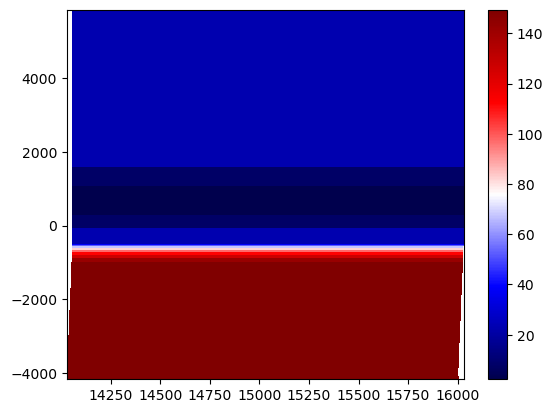

In [70]:
area = 1./pm * 1./pn
print('Shape of area: ', area.shape)
plt.pcolormesh(xisl, yisl, area, cmap='seismic')
plt.colorbar()

In [72]:
bdiff = bathf - bathi
vdiff = bdiff * area
print(np.sum(area))
print(np.sum(bdiff))
print(np.sum(vdiff))
print('bdiff')
stat_summary(bdiff, iprint=True)
print('vdiff')
stat_summary(vdiff, iprint=True)

19821987.311535504
-71339.43
241561.08995808297
bdiff
  n, nnan, nvalid:  1057 0 1057
  mean, std, min, max   : -0.051 0.353 -4.542 1.459
  d5, d25, d50, d75, d95: -0.415 -0.024 0.001 0.018 0.197
vdiff
  n, nnan, nvalid:  1057 0 1057
  mean, std, min, max   : 0.174 1.938 -52.342 70.082
  d5, d25, d50, d75, d95: -1.340 -0.139 0.005 0.152 2.618


{'n': 1057,
 'nnan': 0,
 'nvalid': 1057,
 'mean': 0.173526664237249,
 'std': 1.9381291775885732,
 'min': -52.34180290820279,
 'max': 70.08207991965664,
 'd5': -1.3402486109754943,
 'd25': -0.13889797541907117,
 'd50': 0.005227989657390729,
 'd75': 0.15211813775380204,
 'd95': 2.6178165913995417}

/tmp/ipykernel_153209/2488111961.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m0=ax0.pcolormesh(xisl, yisl, bdiff, cmap='seismic', vmin=-4, vmax=4)


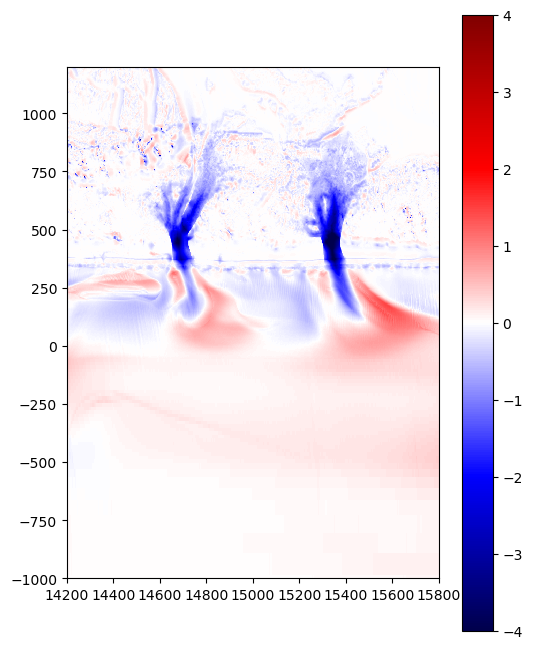

In [75]:
xs = 14200
xe = 15800
ys = -1000
ye = 1200
fig, (ax0) = plt.subplots(1,1,figsize=(6,8),sharex=True)
m0=ax0.pcolormesh(xisl, yisl, bdiff, cmap='seismic', vmin=-4, vmax=4)
ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.set_aspect('equal')
plt.colorbar(m0, ax=ax0)

(-1000.0, 1200.0)

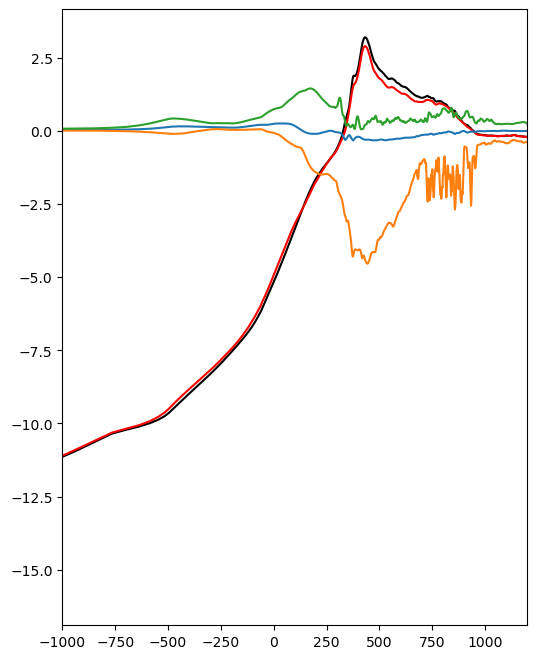

In [97]:
bdprof = running_mean( np.mean(bdiff[:,100:1200], axis=1), 5 )
bdprofmin = running_mean( np.min(bdiff[:,100:1200], axis=1), 5 )
bdprofmax = running_mean( np.max(bdiff[:,100:1200], axis=1), 5 )
y = np.squeeze( yisl[:,550] )
fig, (ax0) = plt.subplots(1,1,figsize=(6,8),sharex=True)
ax0.plot(y, np.mean(bathi[:,100:1200], axis=1), '-k' )
ax0.plot(y, np.mean(bathf[:,100:1200], axis=1), '-r' )

ax0.plot(y,bdprof)
ax0.plot(y,bdprofmin)
ax0.plot(y,bdprofmax)
ax0.set_xlim([ys, ye])

-74223.84361827374


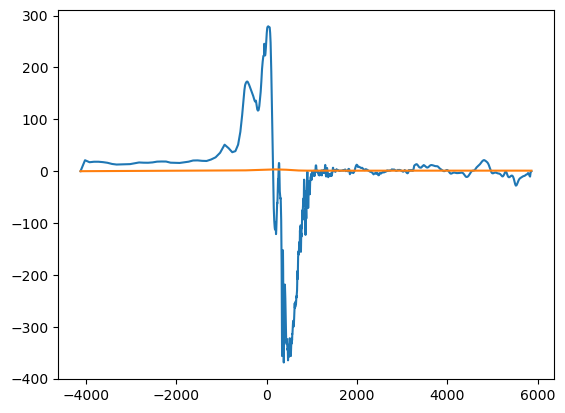

In [68]:
vprof = np.sum(vdiff[:,100:1200], axis=1)
bdprof = np.mean(bdiff[:,100:1200], axis=1)
bmprofi = np.mean(bathi[:,100:1200], axis=1)
bmproff = np.mean(bathi[:,100:1200], axis=1)
bmdprof = bmproff - bmprofi
y = np.squeeze( yisl[:,550] )
dy = np.append( np.diff(y), np.diff(y)[0])
plt.plot(y, bdprof)
plt.plot(y, np.cumsum(bdprof*dy)/np.sum(bdprof*dy) )
print(sum(bdprof))

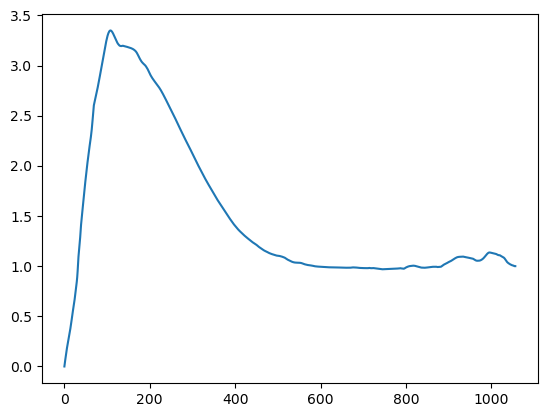

In [55]:
plt.plot(np.cumsum(vprof)/np.sum(vprof))

[ 1.5   3.25  3.5   5.    5.25 10.   15.   17.47 24.92 34.89 44.86 54.83
 64.79 74.76 84.73 94.7  99.68]


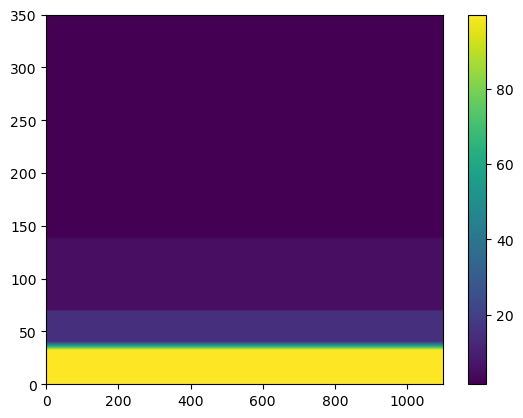

In [26]:
plt.pcolormesh(1./pn[0:350,100:1200])
plt.colorbar()
print(np.unique(np.round(100*1./pn[:,0]))/100.)

In [7]:
nx, ny = np.shape(bathi)
print(nx, ny)
ip = np.arange(0,ny)
icrest = np.ones_like(ip)

1057 1317


In [8]:
# dune crests
for i in ip:
    icrest[i]=np.argmax(-bathi[0:350,i])
    
from scipy.signal import medfilt
icf = medfilt(icrest, 17)

zi = np.ones_like(ip).astype(float)
zif = np.ones_like(ip).astype(float)
for i in ip:
    zi[i] = -bathi[icrest[i],i]
    zif[i]= -bathi[icf[i],i]
    


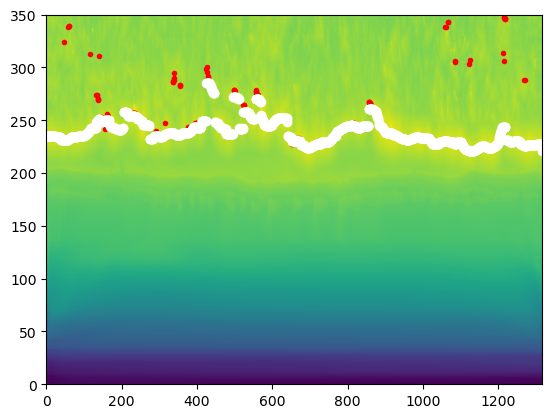

In [9]:
plt.pcolormesh(-bathi[0:350,:])
plt.plot(ip,icrest,'.r')
plt.plot(ip,icf,'ow')

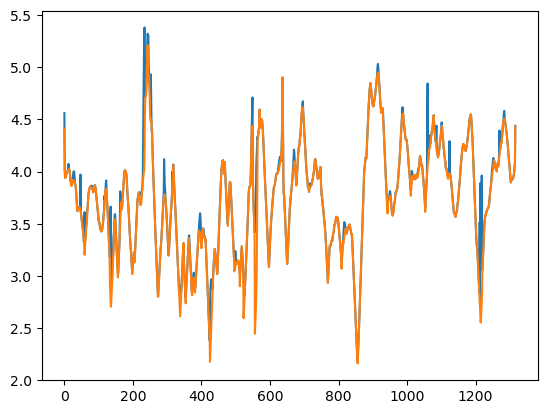

In [10]:
plt.plot(zi)
plt.plot(zif)

246


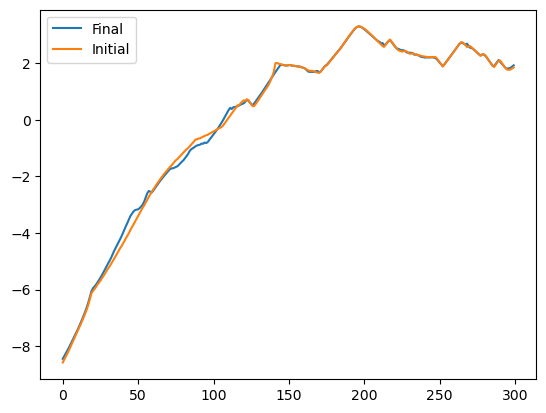

In [11]:
plt.plot(-bathf[50:350,600],label='Final')
plt.plot(-bathi[50:350,600],label='Initial')
plt.legend()
print(np.argmax(-bathi[0:350,600]))

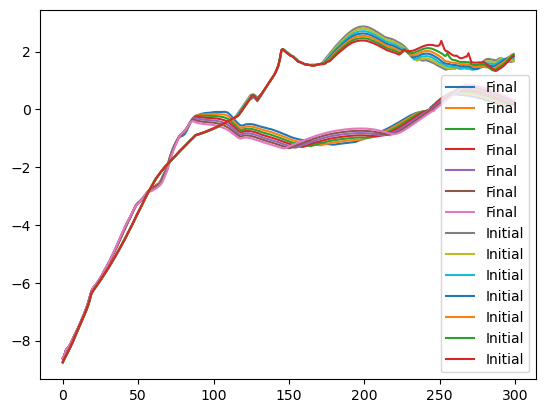

In [12]:
plt.plot(-bathf[50:350,418:425],label='Final')
plt.plot(-bathi[50:350,418:425],label='Initial')
plt.legend()

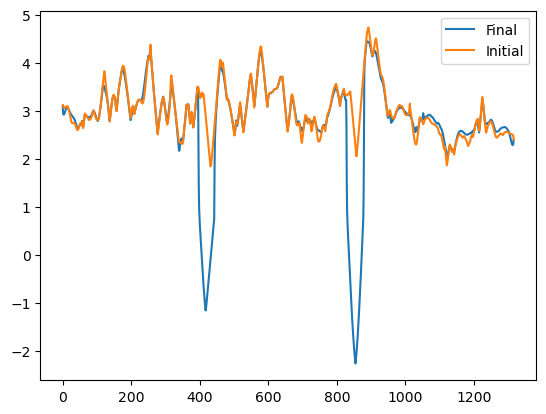

In [13]:
plt.plot(-bathf[245,:],label='Final')
plt.plot(-bathi[245,:],label='Initial')
plt.legend()